In [2]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
# Define the damped sine wave function
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [5]:
data = []
current_group = []
with open('Data\\trussBridgeData.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
data = np.array(data)

In [6]:
#Dataprep:

print(data.shape)
dt = 0.01
T = 2
time = np.arange(0,T,dt)

dataY = []
dataY = np.zeros((121,32,8))

for bridge_ind in range(0, data.shape[0]):
    for node_ind in range(0, data.shape[1]):
        try:
            #Time history for node nr. node_ind in bridge nr. bridge_ind
            node_disp = data[bridge_ind][node_ind]
            #Initial guess for optimized parameters
            A = (np.max(node_disp) - np.min(node_disp)) / 2
            initial_guess = [A, 1, 1, 1]
            #Optimized parameters for simple sine wave
            optimized_parameters, _ = curve_fit(damped_sine_wave, time, node_disp, p0=initial_guess, maxfev=1000)
            #Fitted graph nr. 1
            g1 = damped_sine_wave(time, *optimized_parameters)
            #Error between actual time history and fitted graph
            error = node_disp - g1
            #Optimized parameters for the error graph
            optimized_parameters_2, _ = curve_fit(damped_sine_wave, time, error, p0=initial_guess)
            #Initital guess for the double sine wave function are the 8 optimized parameters from above
            initial_guess_2 = (*optimized_parameters, *optimized_parameters_2)
            #Finished fitted graph
            try: #try to fit a better graph
                optimized_parameters_3, _ = curve_fit(damped_sine_wave_2, time, node_disp, p0=initial_guess_2)
            except: #return the first fitted graph if it doesn't work
                optimized_parameters_3 = [*optimized_parameters,0,0,0,0]
            #Set the 8 optimized parameters as replacement to the 2000 displacements 
            #at the right spot of the label matrix dataY
            dataY[bridge_ind][node_ind] = [*optimized_parameters_3]
        except:
            continue




(121, 32, 200)


c:\Users\kt\OneDrive - NTNU\Master thesis\03_Herman\masters2023\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\kt\AppData\Local\Temp\ipykernel_21192\3633849750.py:6: RuntimeWarning: overflow encountered in exp
  return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)
C:\Users\kt\AppData\Local\Temp\ipykernel_21192\3633849750.py:6: RuntimeWarning: overflow encountered in multiply
  return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)


In [10]:
dataY = np.array(dataY)
print(dataY.shape)
np.save("Data\\trussDataY", dataY)


(121, 32, 8)


In [12]:
dataY2 = np.load("Data\\trussDataY.npy")
print(dataY2.shape)

(121, 32, 8)


In [15]:
points_data = np.loadtxt("Data\\trussBridgePoints.txt")
dataX = np.zeros((121, 32, 4))
bridge_ind = 0
for row_ind in range(0, points_data.shape[0], 3):
    for node_ind in range(0, points_data.shape[1]):
        dataX[bridge_ind][node_ind] = \
        [node_ind, 
         points_data[row_ind][node_ind],
         points_data[row_ind + 1][node_ind],
         points_data[row_ind + 2][node_ind]]
    bridge_ind += 1
print(dataX.shape)
np.save("Data\\trussDataX",dataX)

(121, 32, 4)


In [17]:
edge_index_data = np.loadtxt("Data\\trussBridgeEdge_Index.txt")
dataEdgeIndex = edge_index_data.T
np.save("Data\\trussDataEdgeIndex", dataEdgeIndex)

In [29]:
#Create dataset with PyTorch Data objects
data_set = []
for i in range(0, dataY.shape[0]):
    data_set.append(Data(x = torch.from_numpy(dataX[i]).float(), 
                         edge_index = torch.from_numpy(dataEdgeIndex).long(),
                         y = torch.from_numpy(dataY[i]).float(),
                         bridge_id = i))
print(data_set[0])
#shuffle and save data
from random import shuffle
shuffle(data_set)

torch.save(data_set, "Data\\trussDataObjects")

Data(x=[32, 4], edge_index=[2, 136], y=[32, 8], bridge_id=0)


In [22]:
print(len(data_set))

121


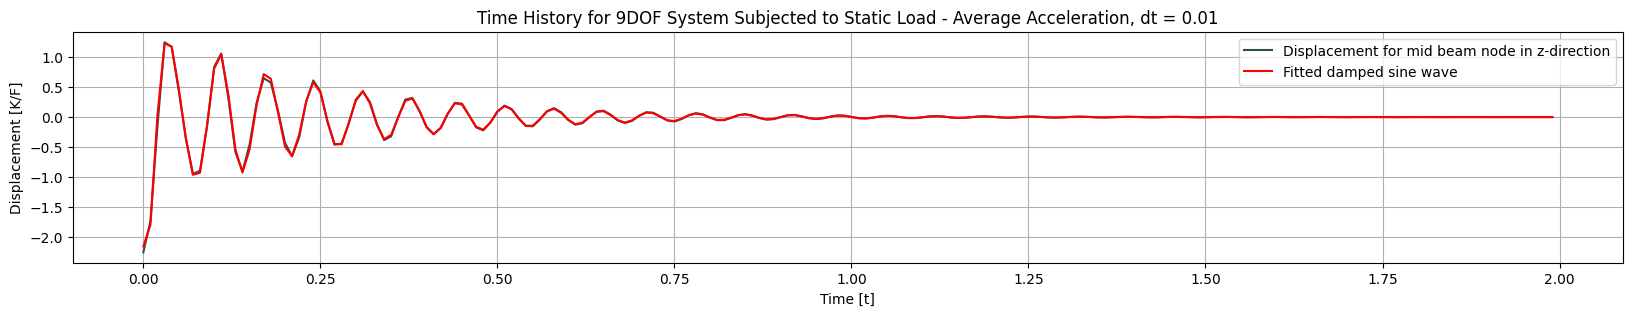

(121, 32, 200)
(121, 32, 8)


In [26]:
fitted = damped_sine_wave_2(time, *dataY[2][4])

title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, data[2][4], color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(data.shape)
print(dataY.shape)

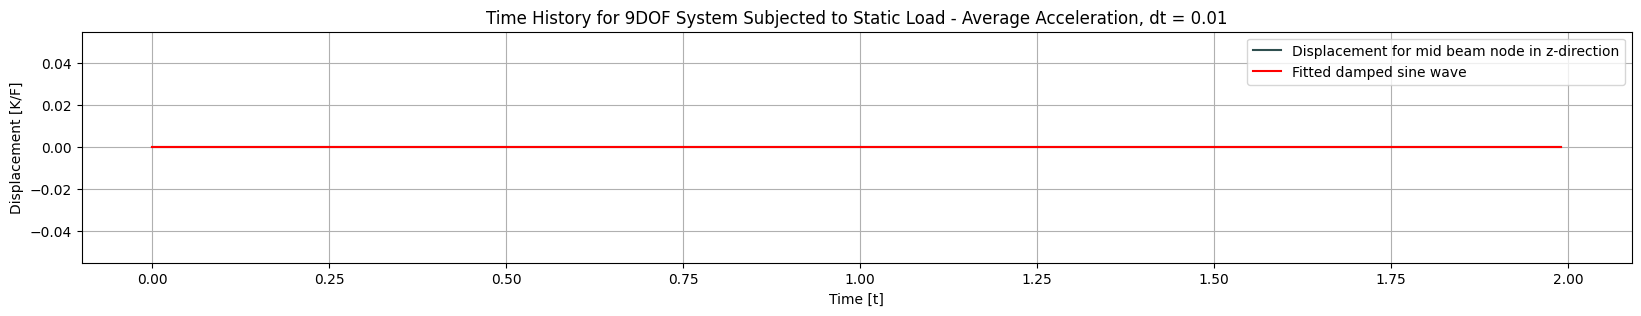

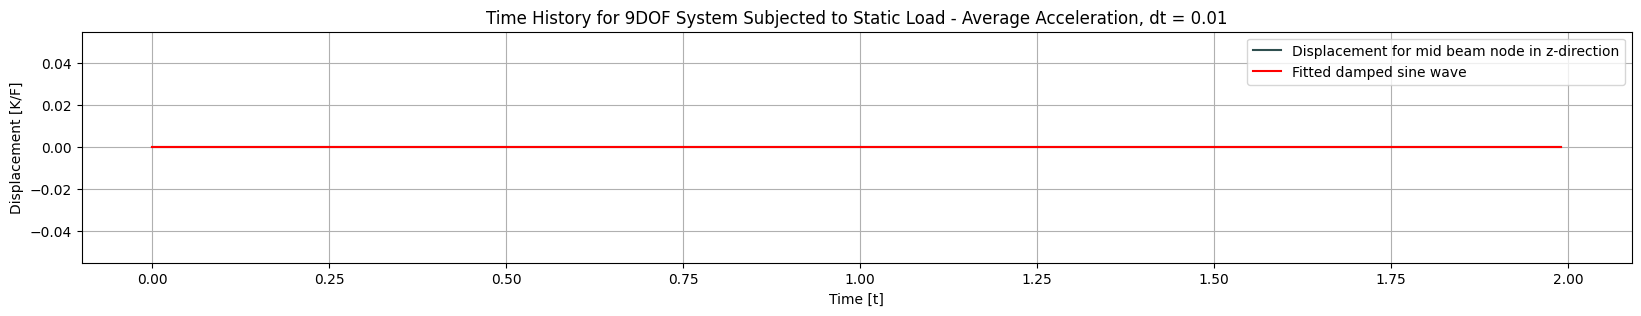

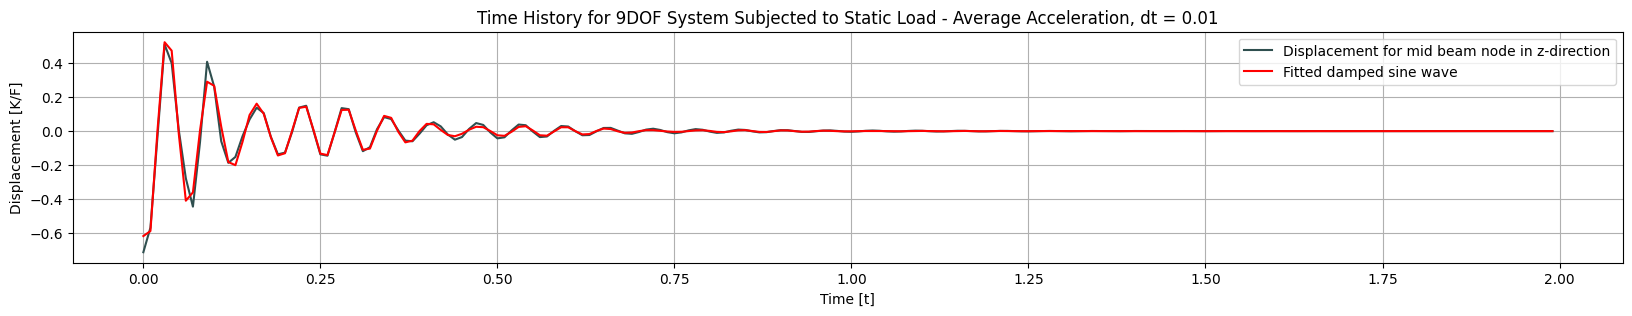

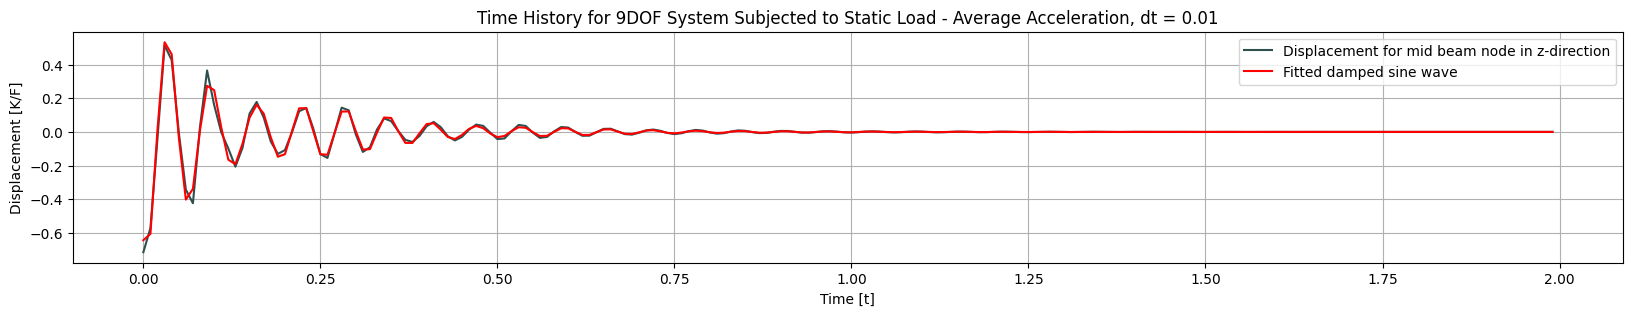

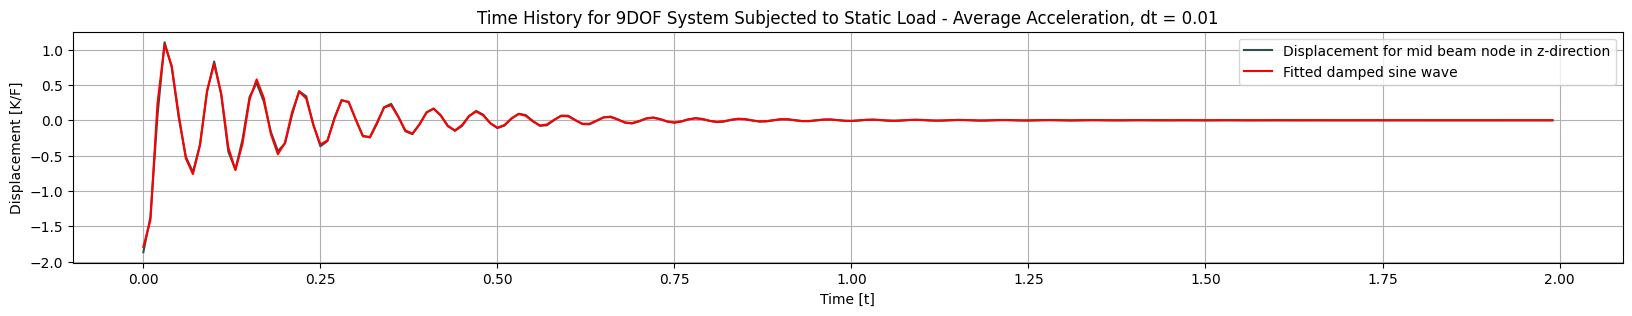

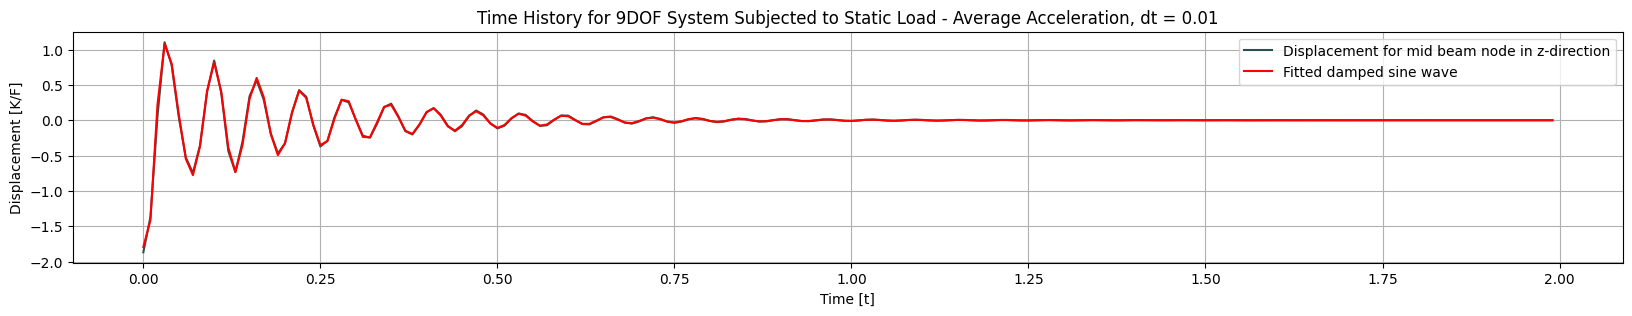

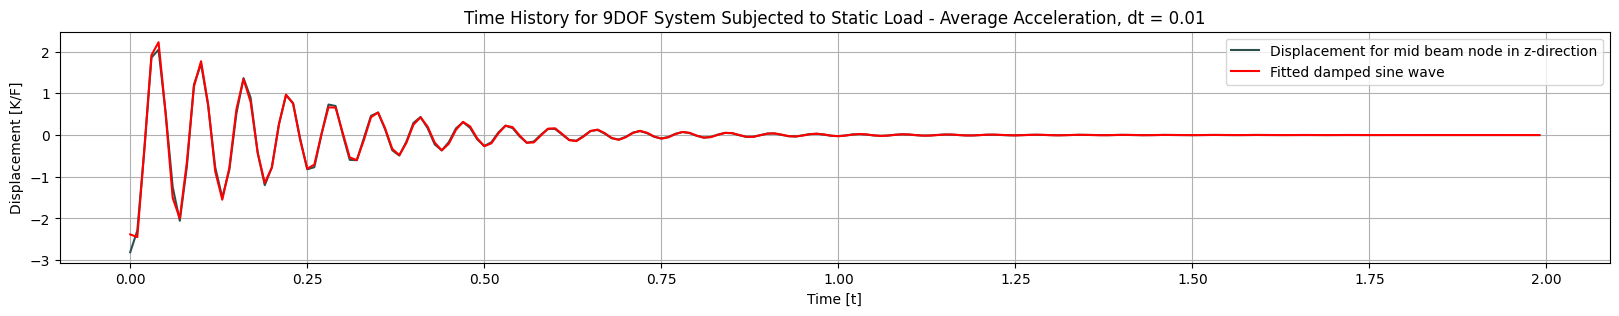

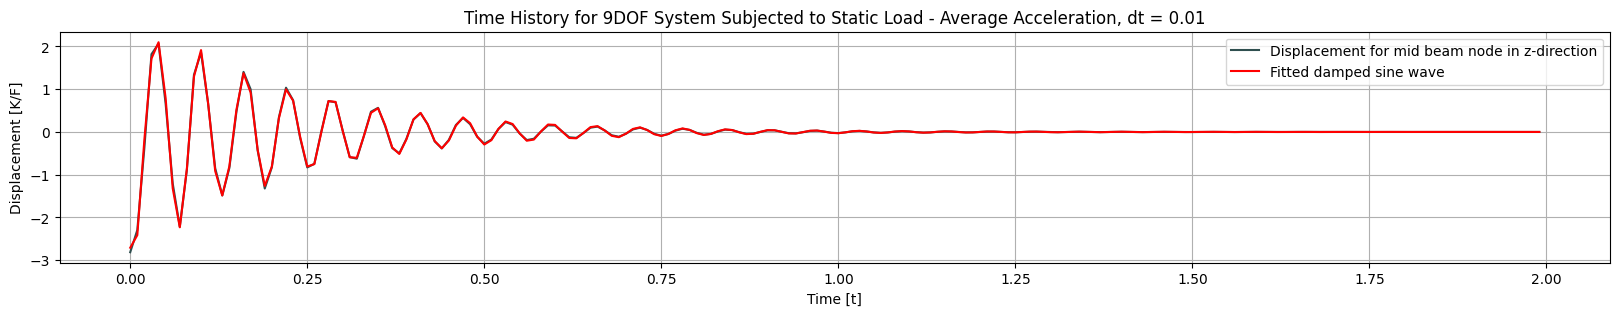

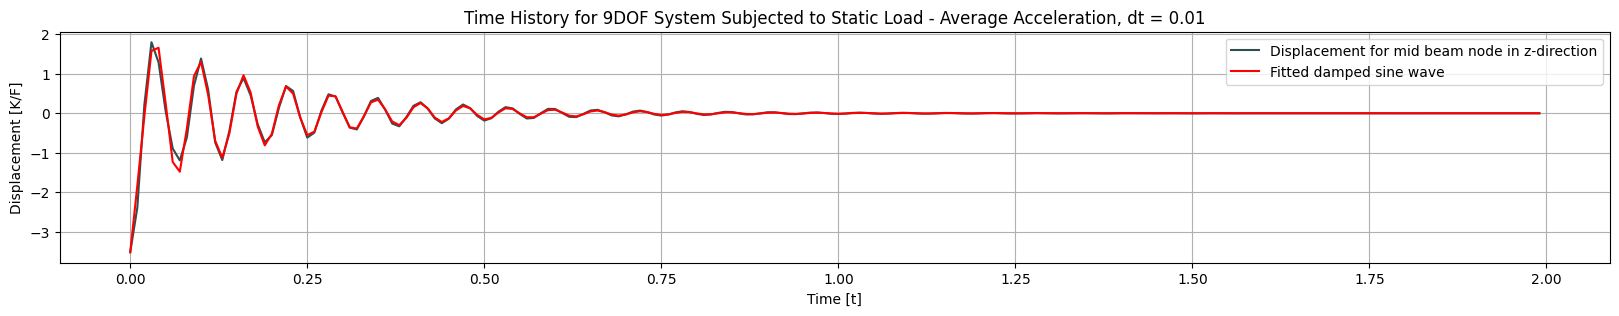

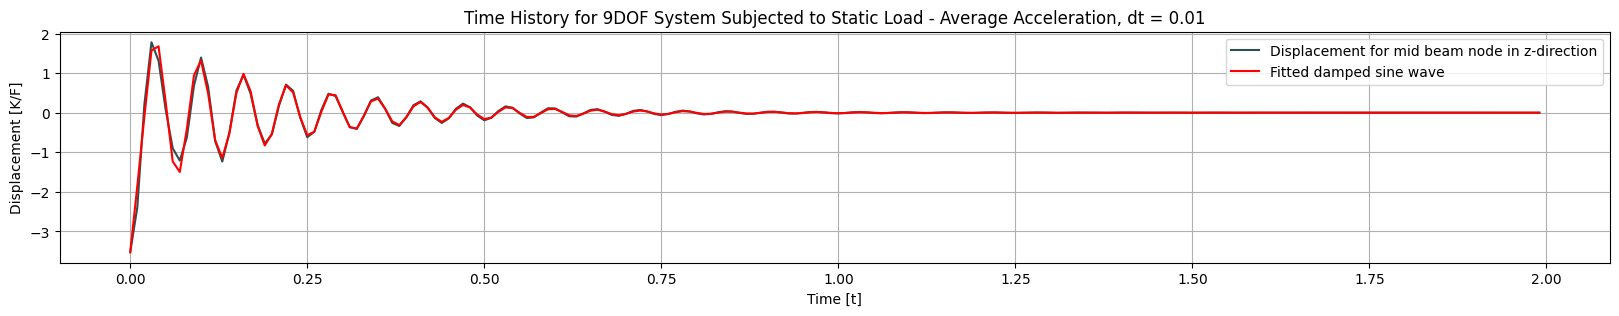

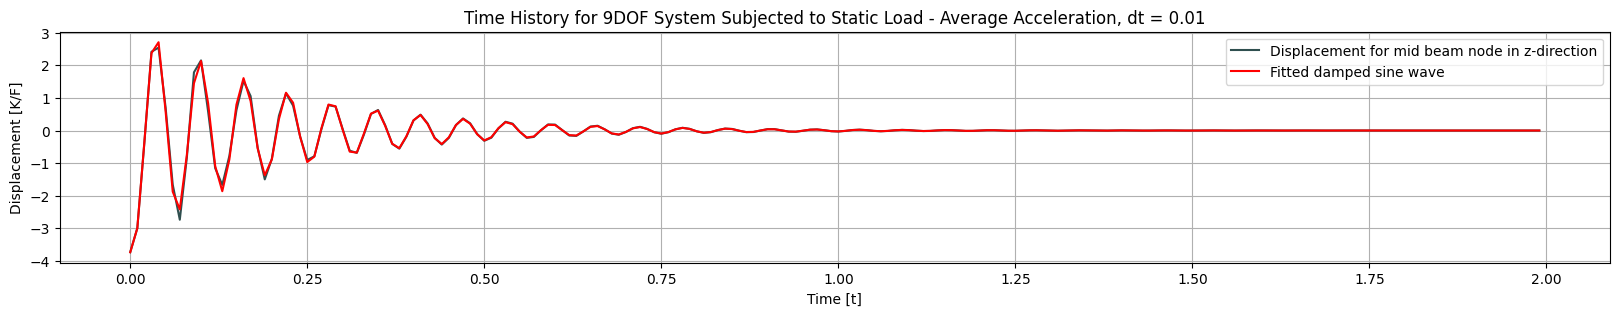

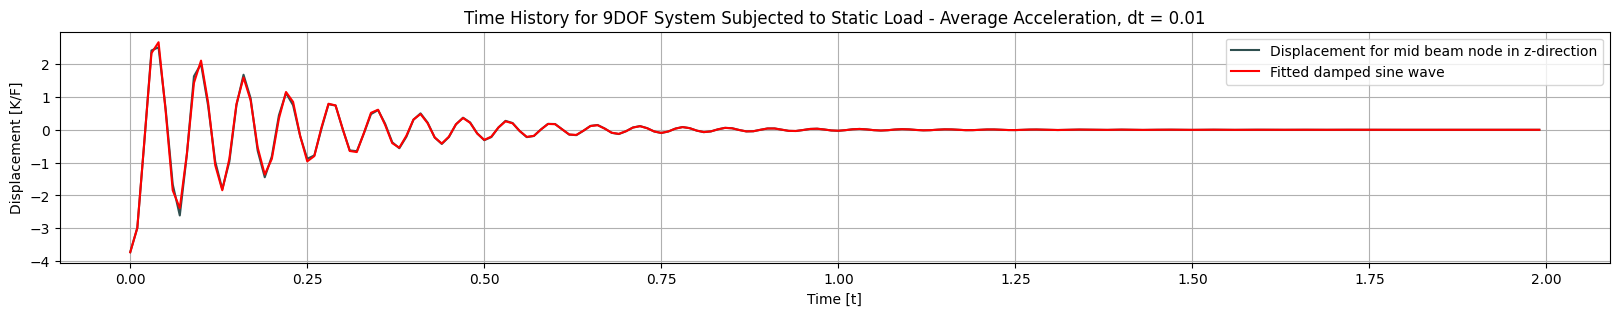

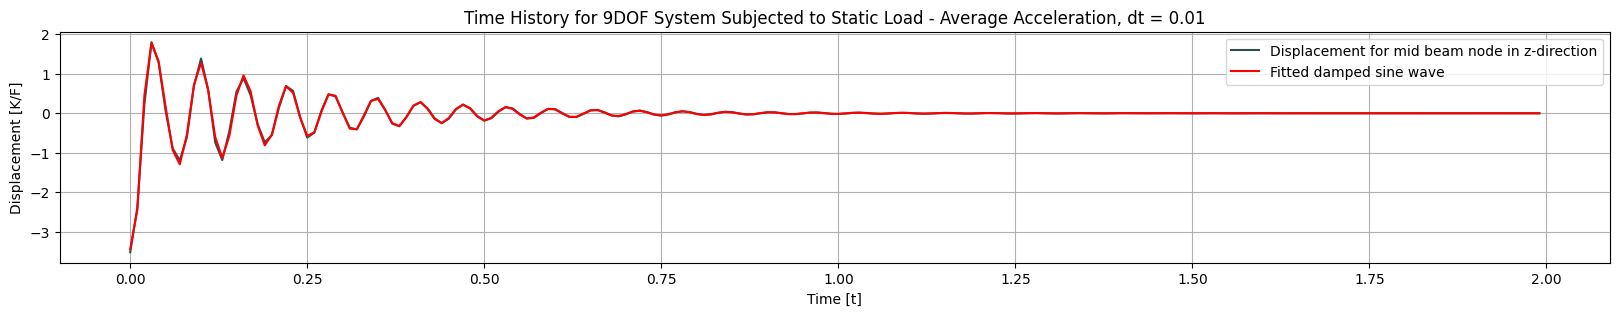

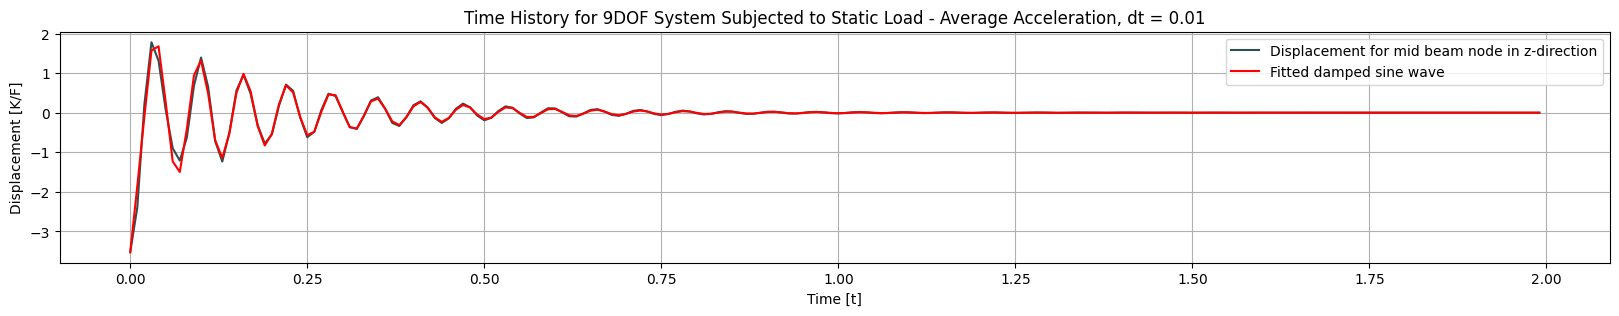

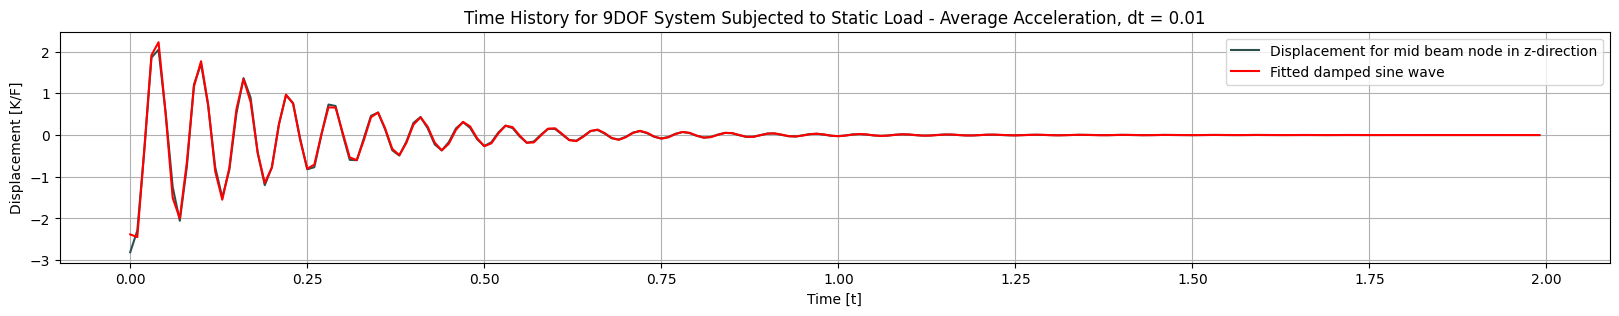

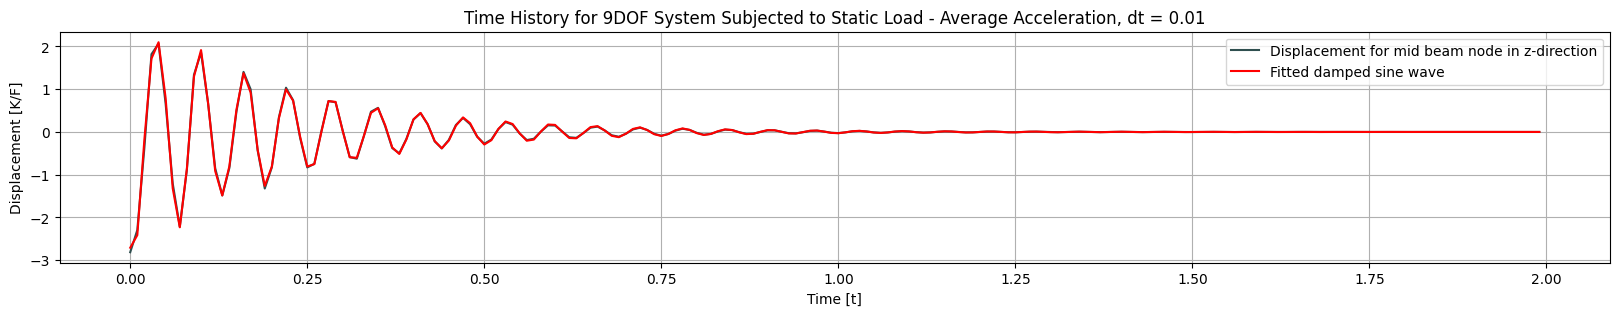

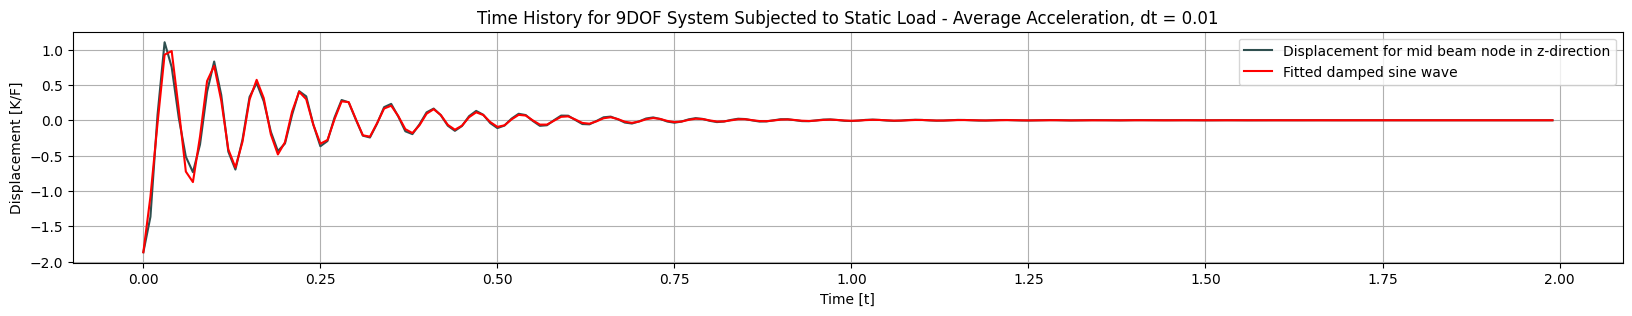

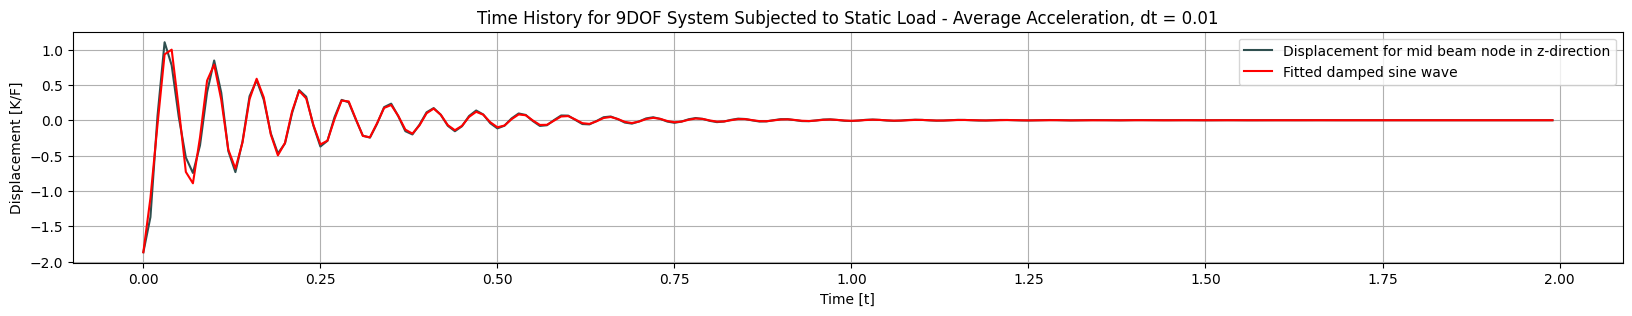

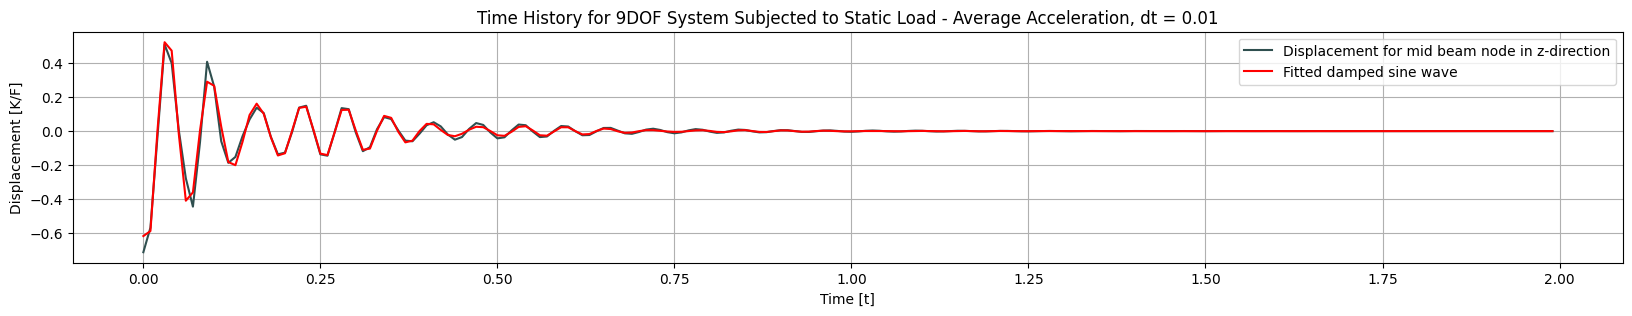

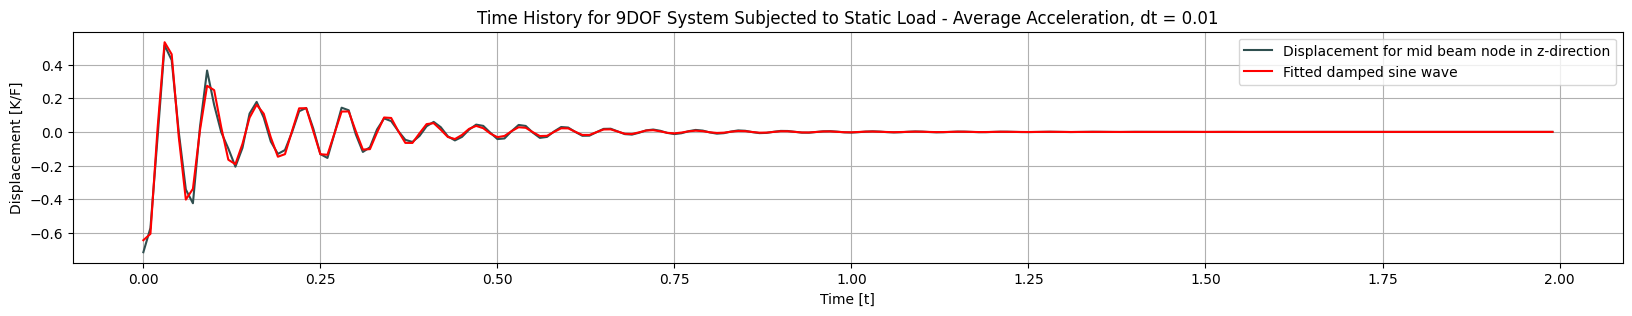

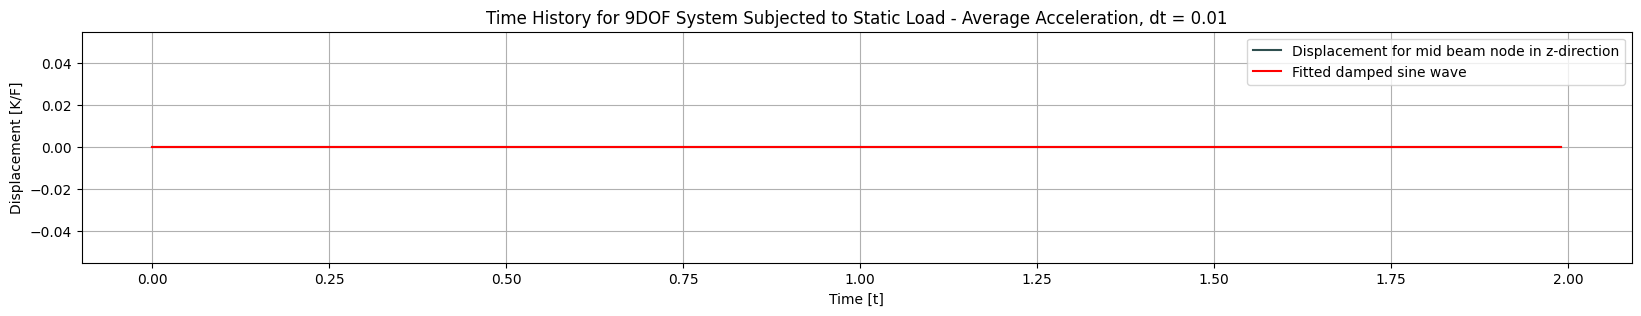

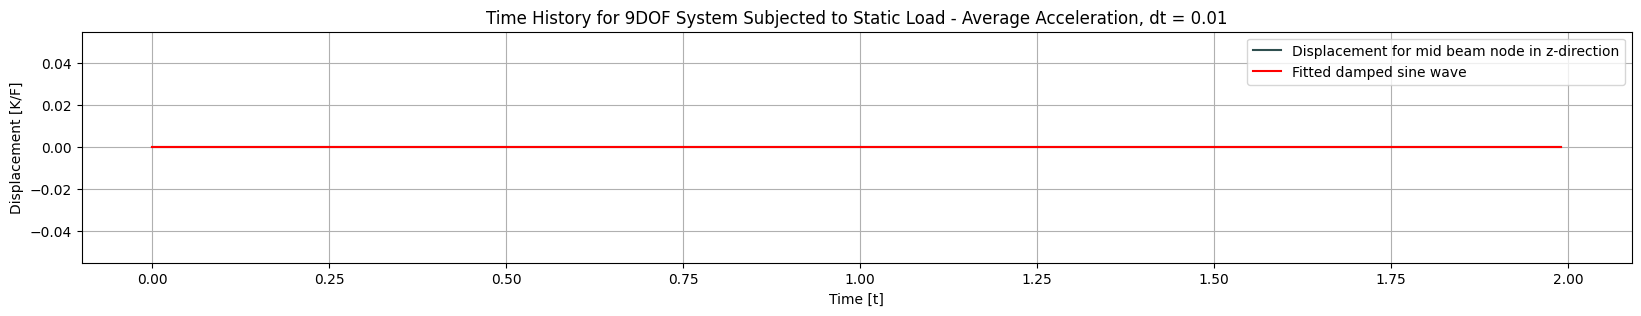

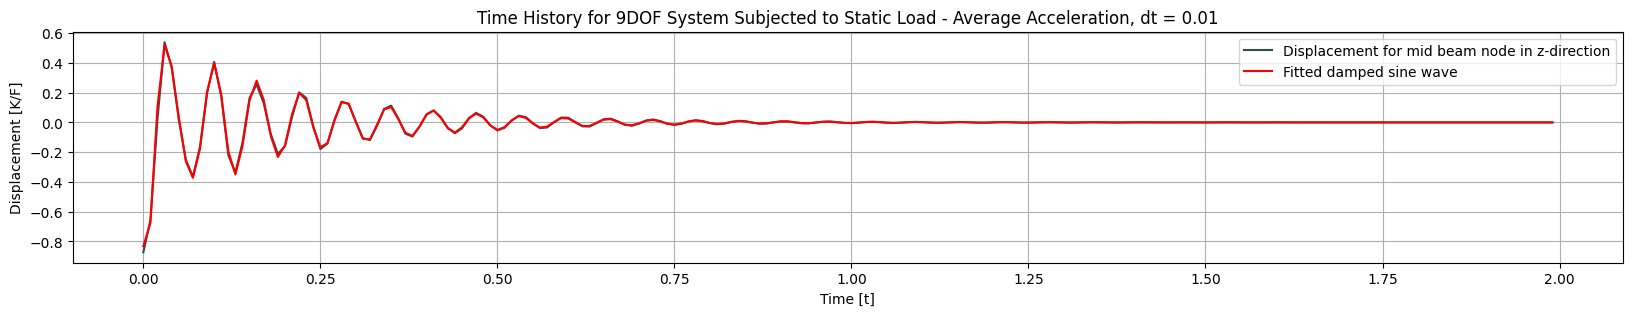

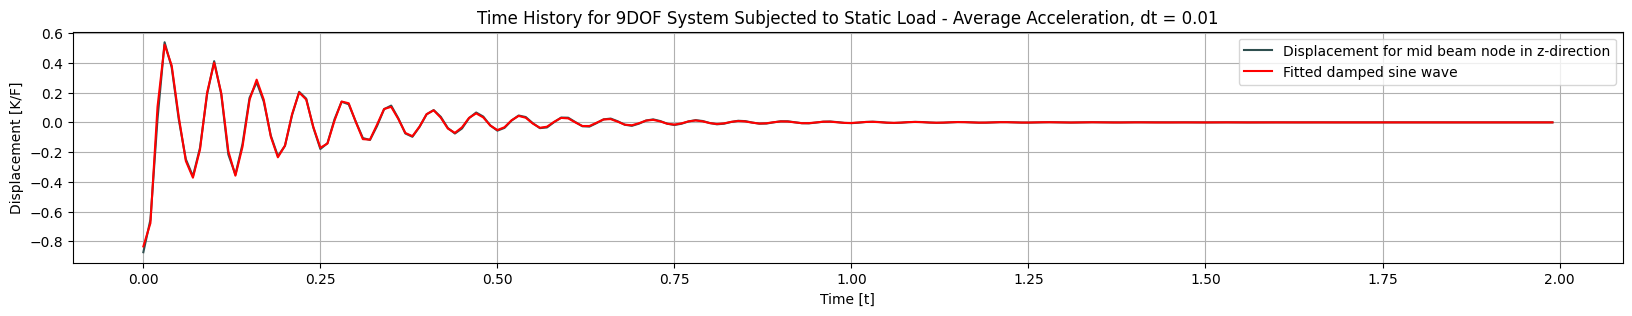

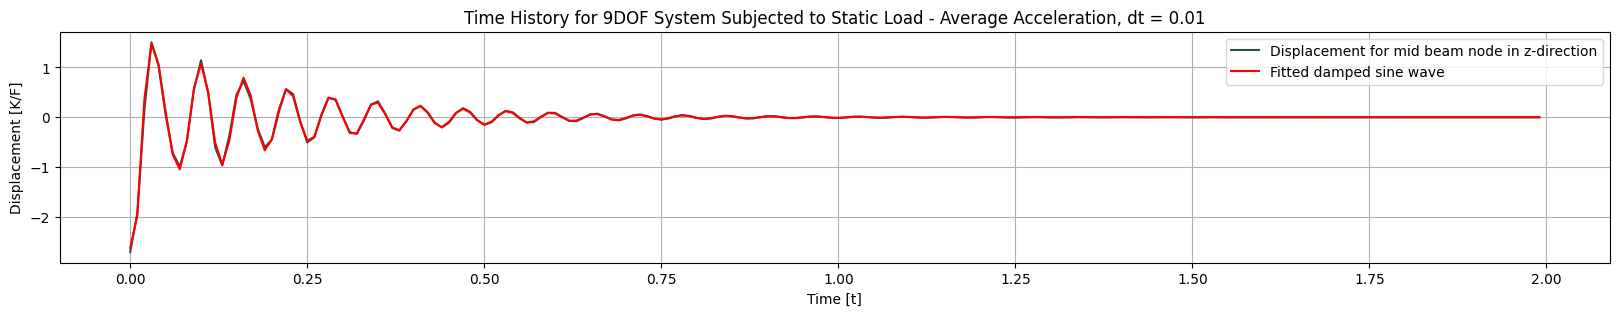

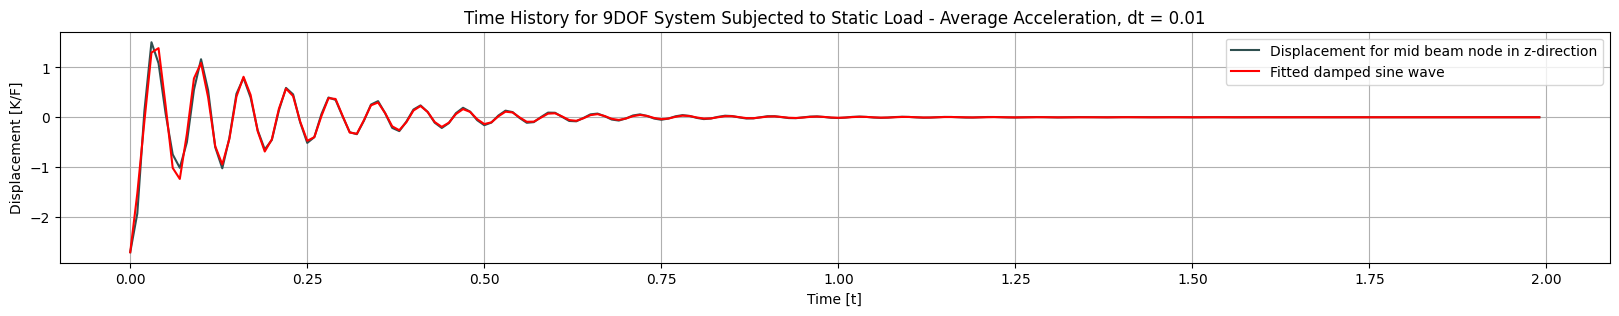

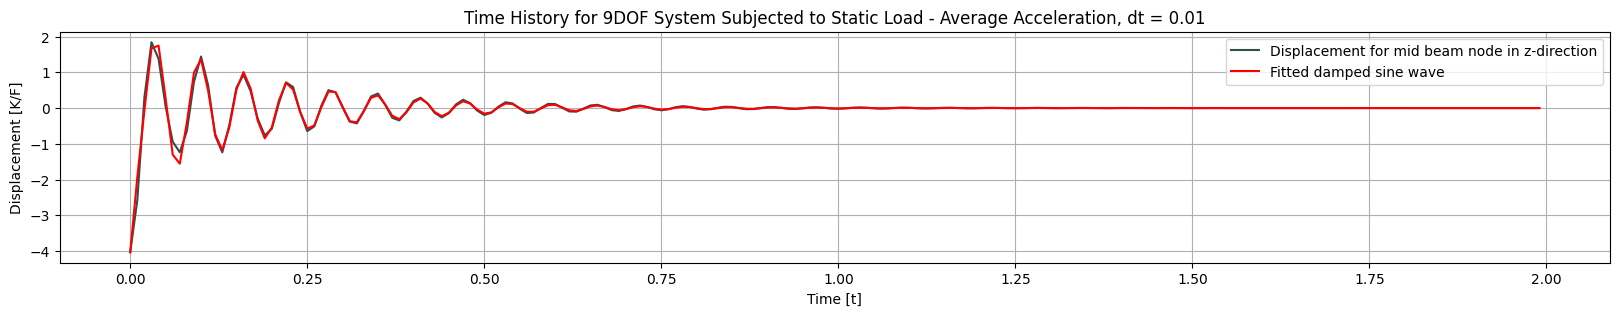

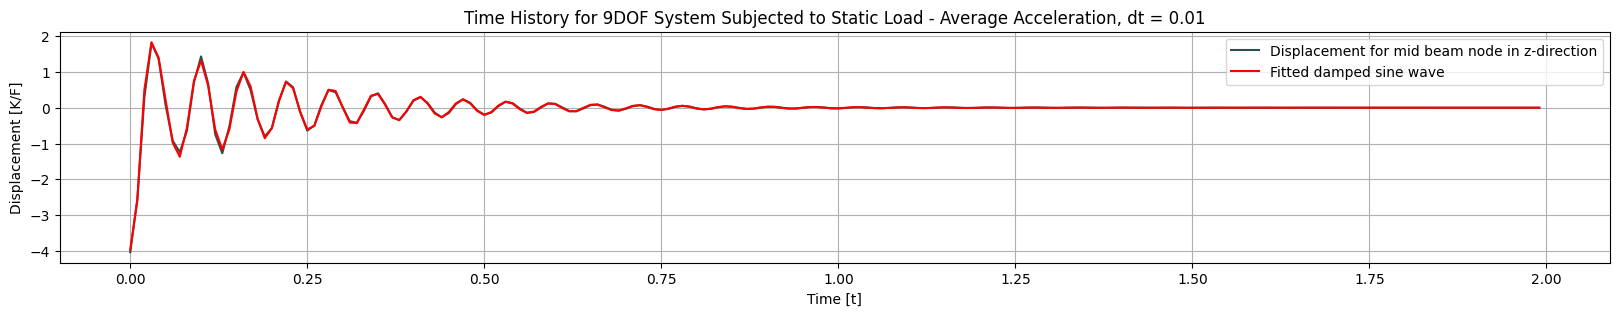

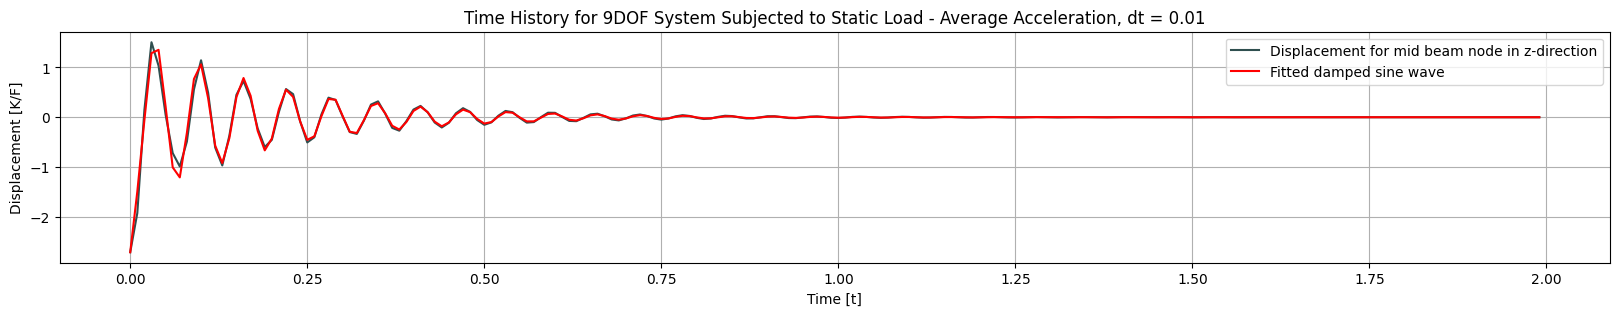

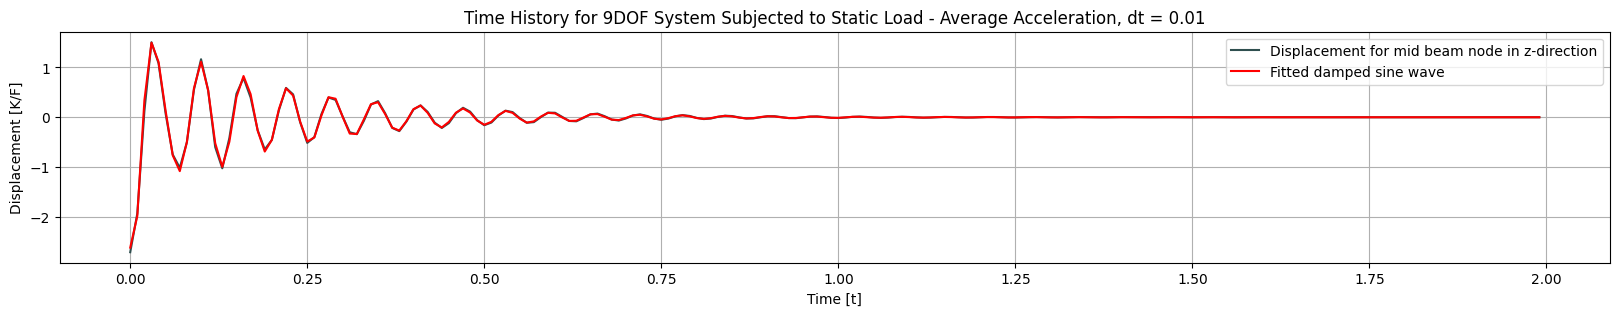

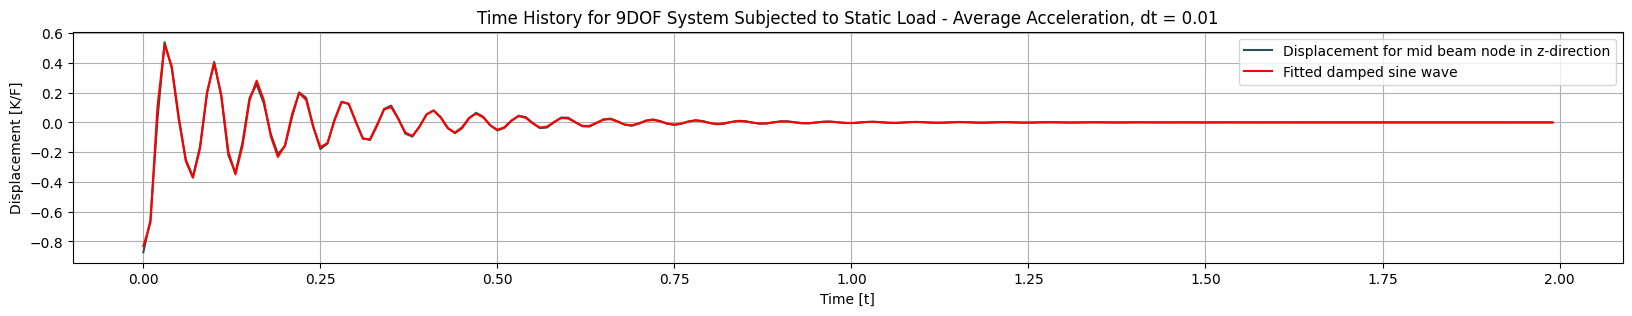

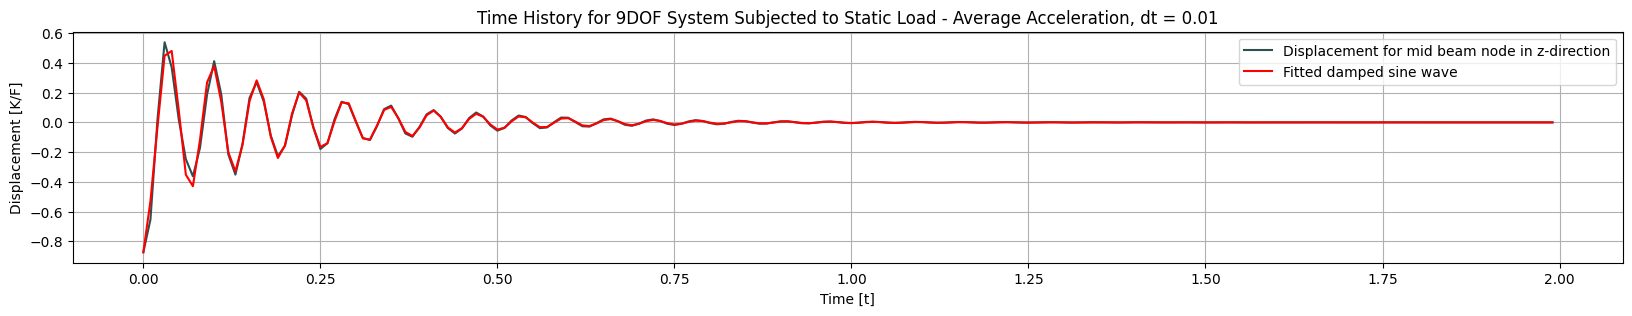

In [73]:
for i in range(data[0].shape[0]):
    fitted = damped_sine_wave_2(time, *dataY[0][i])

    title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(3)
    plt.plot(time, data[0][i], color='darkslategrey', label='Displacement for mid beam node in z-direction')
    plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
    #plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
    plt.xlabel('Time [t]')
    plt.ylabel('Displacement [K/F]')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()